# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([17,18,19])  # new_rides.hour.unique()
prices_ = np.array([5*(i) for i in range(10)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = g[np.where(cab_types_=='Uber'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))
g_lyft = g[np.where(cab_types_=='Lyft'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))

prices_ = prices_.reshape((-1,1))

print(f'g_uber = \n{g_uber}')
print(f'g_lyft = \n{g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e-6
lambda_p2 = 1e-6

eta_p1 = 1e-3
eta_p2 = 1e-3

mu_p1 = -0.1*g_uber
gamma_p1 = 0.05*g_uber
mu_p2 = -0.1*g_lyft
gamma_p2 = 0.05*g_lyft

g_uber = 
[[  0.        ]
 [122.23529412]
 [ 52.11764706]
 [ 51.11764706]
 [  8.58823529]
 [ 42.11764706]
 [  1.41176471]
 [  0.23529412]
 [  0.        ]
 [  0.        ]]
g_lyft = 
[[13.29411765]
 [76.05882353]
 [76.64705882]
 [54.11764706]
 [ 9.        ]
 [39.52941176]
 [ 8.        ]
 [ 1.05882353]
 [ 0.17647059]
 [ 0.29411765]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(2,6,5,dtype='int')
num_test = 10000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [6]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 100
---------------------
Player 1: mu error
2.2512678305570533
Player 1: gamma error
3.85391332142977
Player 1 Risk:
-3271.4174667469874
Player 1: mu error
2.6351252985040388
Player 1: gamma error
2.666555466069211
Player 1 Risk:
-3454.701876565883
---------------------
num_rounds = 1000
---------------------
Player 1: mu error
0.8300971728144187
Player 1: gamma error
0.6936940628174908
Player 1 Risk:
-3223.5600746882387
Player 1: mu error
0.9167735553541156
Player 1: gamma error
0.9166696597780509
Player 1 Risk:
-3445.9197286026156
---------------------
num_rounds = 10000
---------------------
Player 1: mu error
0.431277289161041
Player 1: gamma error
0.16966713262846592
Player 1 Risk:
-3242.798349494107
Player 1: mu error
0.13912073782651566
Player 1: gamma error
0.1556929970102922
Player 1 Risk:
-3518.295004178785
---------------------
num_rounds = 100000
---------------------
Player 1: mu error
0.03201235474387531
Player 1: gamma error
0.10218120887795644
Player 1 Ris

# Run game with DFO players

In [7]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1
eta = 1e-3
num_test_dfo = 1
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test_dfo)

for i in trange(num_rounds+1):
    game_dfo.theta_p1 = player_three.perturb_theta()
    game_dfo.theta_p2 = player_four.perturb_theta()
    
    PR_3_oracle = game_dfo.evaluate_perf_risk_p1()
    PR_4_oracle = game_dfo.evaluate_perf_risk_p2()
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
                                                   mu_p1, gamma_p1,
                                                   lambda_p1,
                                                   game_dfo.theta_p1, game_dfo.theta_p2,
                                                   num_test))
        p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
                                                   mu_p2, gamma_p2,
                                                   lambda_p2,
                                                   game_dfo.theta_p2, game_dfo.theta_p1,
                                                   num_test))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

  0%|                                                                           | 157/1000001 [00:00<33:02, 504.39it/s]

---------------------
Iteration 100
Player 3 risk:
-321.6403094439839
Player 4 risk:
-1052.7830517679588
---------------------


  0%|                                                                          | 1076/1000001 [00:01<26:54, 618.88it/s]

---------------------
Iteration 1000
Player 3 risk:
-857.6759448348347
Player 4 risk:
-1140.0460847943243
---------------------


  1%|▋                                                                        | 10083/1000001 [00:14<23:22, 706.00it/s]

---------------------
Iteration 10000
Player 3 risk:
-1543.4571935610147
Player 4 risk:
-1582.0056317113417
---------------------


 10%|███████▏                                                                | 100059/1000001 [02:18<27:24, 547.34it/s]

---------------------
Iteration 100000
Player 3 risk:
-1837.72316163789
Player 4 risk:
-2397.850841706558
---------------------


100%|███████████████████████████████████████████████████████████████████████| 1000001/1000001 [37:49<00:00, 440.59it/s]

---------------------
Iteration 1000000
Player 3 risk:
-1308.5459343946986
Player 4 risk:
-1405.156026313499
---------------------


## Plots

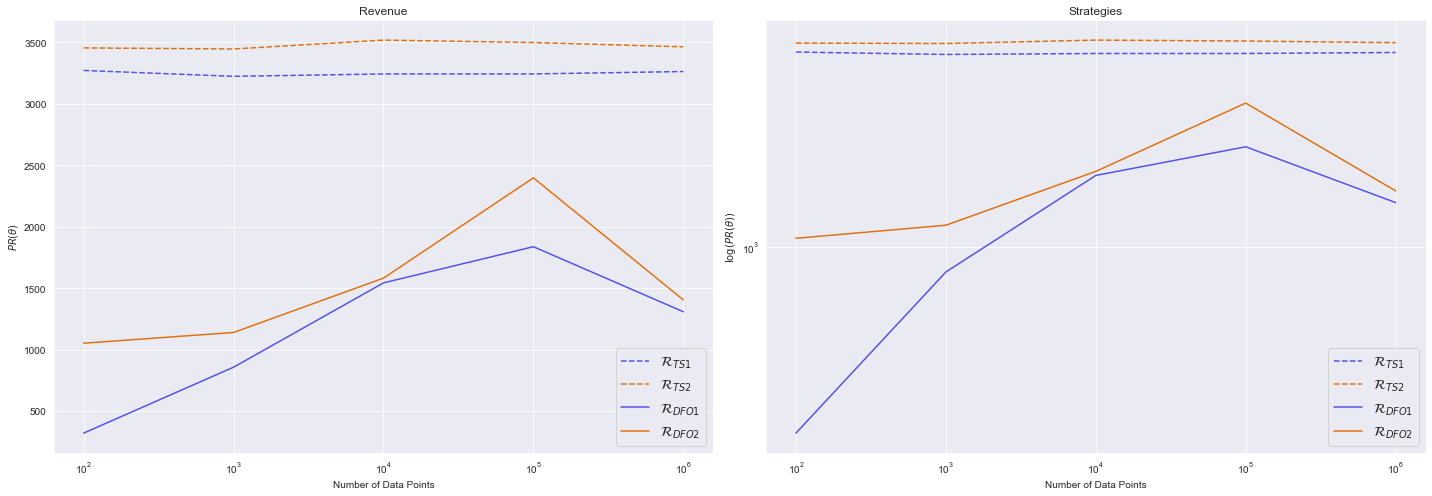

In [8]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
           '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
           '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Strategies')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

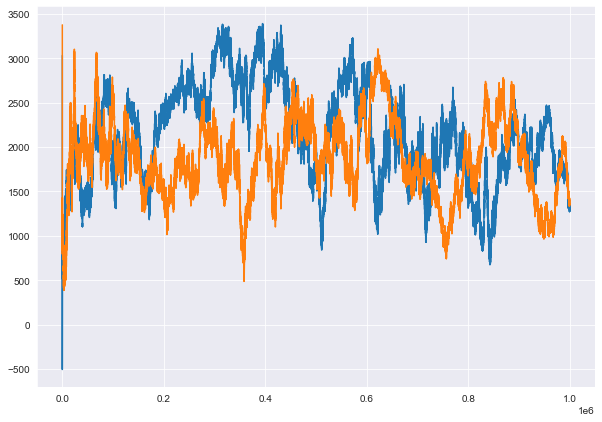

In [9]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

In [10]:
print(f'theta_1_ts - theta_1_dfo = \n{game_ts.theta_p1-game_dfo.theta_p1}')
print(f'theta_2_ts - theta_2_dfo = \n{game_ts.theta_p2-game_dfo.theta_p2}')

theta_1_ts - theta_1_dfo = 
[[ 35.89886061]
 [ -3.35863408]
 [  7.30445699]
 [  5.36426936]
 [-23.53893161]
 [ -8.59695451]
 [ 66.2690244 ]
 [-10.6490021 ]
 [ 50.58093929]
 [  8.53906539]]
theta_2_ts - theta_2_dfo = 
[[-10.91080064]
 [  3.92903466]
 [ -4.03206483]
 [ -2.19102558]
 [ -6.34230864]
 [ -3.44043003]
 [ -1.71218803]
 [ 77.84165124]
 [ -0.2382514 ]
 [ -4.49297752]]


In [11]:
print(f'theta_1_ts = \n{game_ts.theta_p1}')
print(f'theta_2_ts = \n{game_ts.theta_p2}')

theta_1_ts = 
[[-6.36796021e-02]
 [ 3.32077312e+00]
 [-1.88671111e-03]
 [-3.21230243e+00]
 [-3.07357879e+00]
 [-9.24072497e+00]
 [-3.74061484e+00]
 [-4.34116159e-01]
 [ 8.87308384e-01]
 [-1.32304619e+00]]
theta_2_ts = 
[[ 3.21198568]
 [ 3.31263065]
 [-0.01289473]
 [-3.22151769]
 [-2.31898356]
 [-9.19340108]
 [-4.46186672]
 [-0.86638353]
 [-0.88928592]
 [-0.33938626]]


In [12]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2}')

theta_1_dfo = 
[[-35.96254021]
 [  6.67940721]
 [ -7.3063437 ]
 [ -8.57657179]
 [ 20.46535282]
 [ -0.64377046]
 [-70.00963923]
 [ 10.21488594]
 [-49.69363091]
 [ -9.86211159]]
theta_2_dfo = 
[[ 14.12278633]
 [ -0.61640401]
 [  4.0191701 ]
 [ -1.03049211]
 [  4.02332508]
 [ -5.75297105]
 [ -2.74967869]
 [-78.70803478]
 [ -0.65103452]
 [  4.15359126]]
